<a href="https://colab.research.google.com/github/kubernetes-world/3666-ANLP-Predicting-ECB-Monetary-Policy/blob/main/LSTM-Final-SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diskcache
!pip install boto3
!pip install scikeras

In [ ]:
import os
import pandas as pd
import numpy as np

import unicodedata

from itertools import groupby
from unicodedata import category as unicat

import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

from nltk import word_tokenize, pos_tag
from nltk.chunk import tree2conlltags
from nltk.chunk.regexp import RegexpParser
from nltk.corpus import wordnet as wn
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize

from sklearn.base import BaseEstimator, TransformerMixin

from tensorflow.keras.utils import pad_sequences

# Download cleaned data prepared in previous notebooks

In [3]:
from google.colab import userdata
import boto3

s3 = boto3.client("s3", aws_access_key_id=userdata.get('AWS_ACCESS_KEY_ID'), aws_secret_access_key=userdata.get('AWS_SECRET_ACCESS_KEY'))
s3.download_file("3666-applied-nlp", "KeyphraseExtractor.cache.tar.gz", "KeyphraseExtractor.cache.tar.gz")
s3.download_file("3666-applied-nlp", "rate_speeches.sent_tokenize.parquet.gzip", "rate_speeches.sent_tokenize.parquet.gzip")


In [4]:

RATE_SPEECHES_TOKENIZED_FILE = 'rate_speeches.sent_tokenize.parquet.gzip'
assert os.path.exists(RATE_SPEECHES_TOKENIZED_FILE), f"file not present: {RATE_SPEECHES_TOKENIZED_FILE}"

rate_speeches = pd.read_parquet(RATE_SPEECHES_TOKENIZED_FILE)
print(f"rate_speeches.shape: {rate_speeches.shape}")


rate_speeches.shape: (3434, 17)


In [ ]:
!tar zxvf KeyphraseExtractor.cache.tar.gz

In [6]:

from diskcache import Cache
cache = Cache('KeyphraseExtractor.cache')


# `KeyphraseExtractor` transformer

In [7]:
# from joblib import Memory
# location = 'keyphrase_extractor_cachedir'
# memory = Memory(location, verbose=0)

from tqdm import tqdm

class KeyphraseExtractor(BaseEstimator, TransformerMixin):
    """
    Extract adverbial and adjective phrases, and transform
    documents into lists of these keyphrases, with a total
    keyphrase lexicon limited by the nfeatures parameter
    and a document length limited/padded to doclen
    """
    def __init__(self, nfeatures: int, doclen: int):
        self.grammar = r'KT: {(<RB.> <JJ.*>|<VB.*>|<RB.*>)|(<JJ> <NN.*>)}'
        # self.grammar = r'KT: {(<RB.*> <VB.>|<RB.>|<JJ.> <NN.*>)}'
        # self.grammar = r'KT: {<RB.>|<JJ.>}'
        self.chunker = RegexpParser(self.grammar)
        self.nfeatures = nfeatures
        self.doclen = doclen
        # self.normalize = memory.cache(self.normalize)
        # self.extract_candidate_phrases = memory.cache(self.extract_candidate_phrases)

    def normalize(self, sent):
        """
        Removes punctuation from a tokenized/tagged sentence and
        lowercases words.
        """
        is_punct = lambda word: all(unicat(c).startswith('P') for c in word)
        sent = filter(lambda t: not is_punct(t[0]), sent)
        sent = map(lambda t: (t[0].lower(), t[1]), sent)
        return list(sent)

    # NOTE: wrap with memoizing function using cache
    # repeated calls with the same arguments will lookup result in cache and avoid function evaluation.
    @cache.memoize()
    def extract_candidate_phrases(self, sents):
        """
        For a document, parse sentences using our chunker created by
        our grammar, converting the parse tree into a tagged sequence.
        Extract phrases, rejoin with a space, and yield the document
        represented as a list of it's keyphrases.
        """
        result = []
        for sent in sents:
            tokens = word_tokenize(sent)
            pos_tags = pos_tag(tokens)
            normalized = self.normalize(pos_tags)

            chunks = tree2conlltags(self.chunker.parse(normalized))
            if not chunks or all(chunk[-1] == 'O' for chunk in chunks):
                # print(f"No valid chunks found in sentence: {sent}")
                continue

            phrases = [
                " ".join(word for word, pos, chunk in group).lower()
                for key, group in groupby(
                    chunks, lambda term: term[-1] != 'O'
                ) if key
            ]
            for phrase in phrases:
                # yield phrase # joblib.Memory can't cache generators
                result.append(phrase)
        return result

    def fit(self, documents, y=None):
        return self

    def get_lexicon(self, keydocs):
        """
        Build a lexicon of size nfeatures
        """
        keyphrases = [keyphrase for doc in keydocs for keyphrase in doc]
        # print("Keyphrases:", keyphrases[:5])
        fdist = FreqDist(keyphrases)
        counts = fdist.most_common(self.nfeatures)
        # print("Frequency counts:", counts[:5])
        lexicon = [phrase for phrase, count in counts]
        return {phrase: idx+1 for idx, phrase in enumerate(lexicon)}

    def clip(self, keydoc, lexicon):
        """
        Remove keyphrases from documents that aren't in the lexicon
        """
        return [lexicon[keyphrase] for keyphrase in keydoc if keyphrase in lexicon.keys()]

    def transform(self, documents):
      keydocs = [list(self.extract_candidate_phrases(doc)) for doc in tqdm(documents)]
      lexicon = self.get_lexicon(keydocs)
      clipped = [list(self.clip(keydoc, lexicon)) for keydoc in keydocs]
      return pad_sequences(clipped, maxlen=self.doclen)


### Build `KeyphraseExtractor.cache` (skip)

In [8]:
%%script false --no-raise-error

# build cache
keyphrase_extractor = KeyphraseExtractor(nfeatures=10000, doclen=100)
keyphrase_extractor.fit_transform(X)

# ---

from google.colab import userdata
import boto3

s3 = boto3.client("s3", aws_access_key_id=userdata.get('AWS_ACCESS_KEY_ID'), aws_secret_access_key=userdata.get('AWS_SECRET_ACCESS_KEY'))
s3.upload_file("KeyphraseExtractor.cache.tar.gz", "3666-applied-nlp", "KeyphraseExtractor.cache.tar.gz")

# ---

!tar -cvzf KeyphraseExtractor.cache.tar.gz KeyphraseExtractor.cache


# LSTM model

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense, Input

def create_lstm_model(vocab_size: int, input_length: int, num_classes: int, compile_loss: str):
    model = Sequential([
        Input(shape=(input_length,), name="input_layer"),  # explicit input layer
        Embedding(input_dim=vocab_size, output_dim=128, name="embedding_layer"),
        LSTM(128, return_sequences=True, name="lstm_layer_1"),
        Dropout(0.2, name="dropout_layer_1"),
        LSTM(64, name="lstm_layer_2"),
        Dropout(0.2, name="dropout_layer_2"),
        Dense(num_classes, activation="softmax", name="output_layer")
    ])
    model.compile(optimizer='adam', loss=compile_loss, metrics=['accuracy'])
    return model


In [22]:
class DebugTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        print(f"LSTM X.shape: {X.shape}")
        # print(f"Sample Data Before LSTM: {X[0]}")  # print a sample
        return X

# Label encoding and train/test splitting

## No Data Leakage

- It is acceptable to call `label_encoder.fit_transform(..)` on the entire set of labels (`rate_speeches["Direction"]`) prior to splitting because `LabelEncoder` is a simple transformation that maps categorical values to numerical labels.

- **It does not learn any information about the dataset beyond the unique classes.**


In [16]:
from sklearn.preprocessing import LabelEncoder

X = rate_speeches["extracted_text"]
print(f"X.shape: {X.shape}")

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(rate_speeches["Direction"])  # integer encoding
print(f"y_encoded.shape: {y_encoded.shape}")


X.shape: (3434,)
y_encoded.shape: (3434,)


In [17]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded)


# `StratifiedKFold` (and choice of `n_splits`)

## 5-Fold Cross-Validation:
- Most commonly used.
- Provides a good balance between bias and variance of the performance estimate.

## 10-Fold Cross-Validation:
- Preferred when data is limited and computational cost is acceptable.
- Offers slightly more robust performance estimates but increases computation time.

In [23]:
from sklearn.model_selection import StratifiedKFold

# dynamically determine n_splits based on class distribution
min_class_size = rate_speeches["Direction"].value_counts().min()
print(f"min_class_size: {min_class_size}")

n_splits = min(10, min_class_size)  # use up to 10 splits or the smallest class size
print(f"Using {n_splits}-Fold Cross-Validation")

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


min_class_size: 252
Using 10-Fold Cross-Validation


# Standard `sklearn.pipeline.Pipeline`

In [24]:
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate

pipeline_scce = Pipeline([
    ("keyphrase_extractor",
      KeyphraseExtractor(nfeatures=10000, doclen=100)),
    ('debug', DebugTransformer()),
    ("lstm_classifier",
      KerasClassifier(
        build_fn=create_lstm_model,
        vocab_size=10000,
        input_length=100,
        num_classes=3,
        compile_loss='sparse_categorical_crossentropy',
        epochs=10,
        batch_size=32,
        verbose=1)
    )
])

scores_scce = cross_validate(
    pipeline_scce,
    X_train,
    y_train,
    cv=skf,
    scoring="accuracy",
    return_estimator=True,
    return_train_score=True)


100%|██████████| 2472/2472 [00:02<00:00, 1083.16it/s]


LSTM X.shape: (2472, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8033 - loss: 0.6941
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8458 - loss: 0.4639
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8998 - loss: 0.2355
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9615 - loss: 0.1310
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9933 - loss: 0.0312
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9947 - loss: 0.0239
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9956 - loss: 0.0160
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9994 - loss: 0.0044
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9990 - loss: 0.0042
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9989 - loss: 0.0040


100%|██████████| 275/275 [00:00<00:00, 1078.77it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1107.33it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1096.06it/s]


LSTM X.shape: (2472, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8008 - loss: 0.7234
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8495 - loss: 0.4835
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9110 - loss: 0.2616
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9661 - loss: 0.1073
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9882 - loss: 0.0522
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9964 - loss: 0.0175
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9991 - loss: 0.0063
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9949 - loss: 0.0160
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9979 - loss: 0.0116
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9984 - loss: 0.0052


100%|██████████| 275/275 [00:00<00:00, 1087.28it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1122.67it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1073.51it/s]


LSTM X.shape: (2472, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7990 - loss: 0.7214
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8458 - loss: 0.4947
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9037 - loss: 0.2442
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9796 - loss: 0.0765
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9911 - loss: 0.0357
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9944 - loss: 0.0225
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9971 - loss: 0.0161
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9993 - loss: 0.0050
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9986 - loss: 0.0070
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9974 - loss: 0.0078


100%|██████████| 275/275 [00:00<00:00, 1052.96it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1111.97it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1103.73it/s]


LSTM X.shape: (2472, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8065 - loss: 0.7120
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8552 - loss: 0.4489
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8992 - loss: 0.2278
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9497 - loss: 0.1329
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9927 - loss: 0.0369
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9937 - loss: 0.0266
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9972 - loss: 0.0264
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9950 - loss: 0.0281
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9965 - loss: 0.0218
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9964 - loss: 0.0145


100%|██████████| 275/275 [00:00<00:00, 1082.26it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1109.92it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1103.74it/s]


LSTM X.shape: (2472, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8112 - loss: 0.6990
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8389 - loss: 0.5053
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9047 - loss: 0.2365
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9617 - loss: 0.1259
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9888 - loss: 0.0406
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9949 - loss: 0.0290
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9961 - loss: 0.0141
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9984 - loss: 0.0062
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9995 - loss: 0.0034
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9997 - loss: 0.0027


100%|██████████| 275/275 [00:00<00:00, 1052.31it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1108.99it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1097.73it/s]


LSTM X.shape: (2472, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8249 - loss: 0.6866
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8463 - loss: 0.4973
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9080 - loss: 0.2652
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9667 - loss: 0.1176
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9931 - loss: 0.0359
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9972 - loss: 0.0144
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9976 - loss: 0.0082
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9979 - loss: 0.0065
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9986 - loss: 0.0043
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9989 - loss: 0.0052


100%|██████████| 275/275 [00:00<00:00, 1091.67it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1097.48it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1088.58it/s]


LSTM X.shape: (2472, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8051 - loss: 0.6990
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8585 - loss: 0.4621
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9203 - loss: 0.2214
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9694 - loss: 0.1201
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9885 - loss: 0.0453
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9734 - loss: 0.1025
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9973 - loss: 0.0183
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9985 - loss: 0.0090
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9986 - loss: 0.0064
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9993 - loss: 0.0037


100%|██████████| 275/275 [00:00<00:00, 1024.88it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1084.22it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1097.05it/s]


LSTM X.shape: (2473, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8127 - loss: 0.7183
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8271 - loss: 0.5430
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8984 - loss: 0.2774
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9610 - loss: 0.1512
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9912 - loss: 0.0426
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9996 - loss: 0.0051
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9977 - loss: 0.0084
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9997 - loss: 0.0048
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9997 - loss: 0.0029
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9988 - loss: 0.0052


100%|██████████| 274/274 [00:00<00:00, 1077.99it/s]


LSTM X.shape: (274, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1106.07it/s]


LSTM X.shape: (2473, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1065.55it/s]


LSTM X.shape: (2473, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8110 - loss: 0.7007
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8402 - loss: 0.5109
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9152 - loss: 0.2608
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9708 - loss: 0.1126
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9885 - loss: 0.0398
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9981 - loss: 0.0133
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9973 - loss: 0.0202
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9976 - loss: 0.0123
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9954 - loss: 0.0158
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9960 - loss: 0.0146


100%|██████████| 274/274 [00:00<00:00, 1110.24it/s]


LSTM X.shape: (274, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1107.15it/s]


LSTM X.shape: (2473, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1081.36it/s]


LSTM X.shape: (2473, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8114 - loss: 0.6983
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8311 - loss: 0.5085
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8826 - loss: 0.2437
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9154 - loss: 0.1332
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9435 - loss: 0.1202
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9857 - loss: 0.0550
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9851 - loss: 0.0432
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9979 - loss: 0.0157
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9965 - loss: 0.0164
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9985 - loss: 0.0073


100%|██████████| 274/274 [00:00<00:00, 1050.27it/s]


LSTM X.shape: (274, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1106.67it/s]


LSTM X.shape: (2473, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [26]:
# print(scores_scce)
print(f"Cross-validation scores: {scores_scce['test_score']}")
print(f"Mean accuracy: {np.mean(scores_scce['test_score']):.2f}")

Cross-validation scores: [0.80727273 0.8        0.78181818 0.78545455 0.76363636 0.78545455
 0.79636364 0.78467153 0.78832117 0.78832117]
Mean accuracy: 0.79


## Model Evaluation

In [27]:

pipeline_scce.fit(X_train, y_train)
y_pred = pipeline_scce.predict(X_test)


100%|██████████| 2747/2747 [00:02<00:00, 1079.67it/s]


LSTM X.shape: (2747, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8068 - loss: 0.6957
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8477 - loss: 0.4360
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9129 - loss: 0.2167
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9341 - loss: 0.1421
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9908 - loss: 0.0407
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9959 - loss: 0.0213
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9980 - loss: 0.0103
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9974 - loss: 0.0082
Epoch 9/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9989 - loss: 0.0061
Epoch 10/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9975 - loss: 0.0092


100%|██████████| 687/687 [00:00<00:00, 1052.93it/s]


LSTM X.shape: (687, 100)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Confusion Matrix:
[[  5   2  52]
 [  1   1  48]
 [ 27  10 541]]



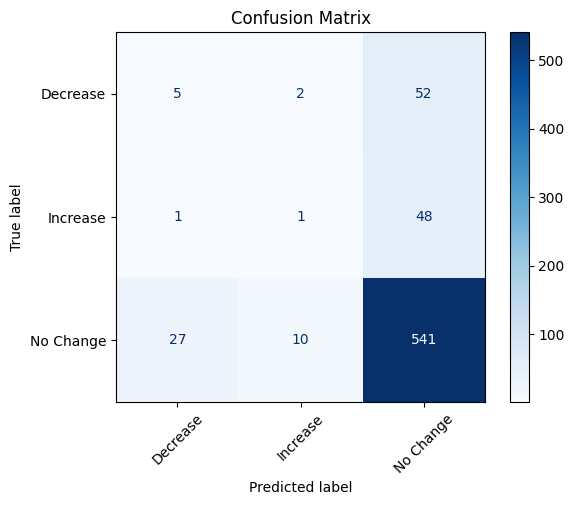


Classification Report:
              precision    recall  f1-score   support

    Decrease       0.15      0.08      0.11        59
    Increase       0.08      0.02      0.03        50
   No Change       0.84      0.94      0.89       578

    accuracy                           0.80       687
   macro avg       0.36      0.35      0.34       687
weighted avg       0.73      0.80      0.76       687



In [28]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=range(len(label_encoder.classes_)))
print(cm)

print()
# display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Synthetic Minority Over-sampling TEchnique (`SMOTE`) for imbalanced data

## Cross-Validation:

- Perform cross-validation with a pipeline to ensure that `SMOTE` is applied only on the training data in each fold.

## Use `imblearn.pipeline.Pipeline`:

- The `Pipeline` class in `imblearn` is specifically designed for scenarios where the pipeline modifies both X and y, such as oversampling with `SMOTE`.

## The `SMOTE` pipeline step:

- We place SMOTE after the `KeyphraseExtractor` preprocessing steps (as we would do with scaling or encoding) to ensure `SMOTE` operates on the transformed data.

## Avoiding data leakage:

- When using `Pipeline` with `SMOTE`, oversampling is applied only to the training folds during cross-validation.
- This avoids data leakage into the validation set, which would inflate performance metrics.


In [29]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbalancedPipeline

imbalanced_pipeline = ImbalancedPipeline(steps=[
    ("keyphrase_extractor",
      KeyphraseExtractor(nfeatures=10000, doclen=100)),
    ("smote",
      SMOTE(random_state=42)),
    ('debug', DebugTransformer()),
    ("lstm_classifier",
      KerasClassifier(
        build_fn=create_lstm_model,
        vocab_size=10000,
        input_length=100,
        num_classes=3,
        compile_loss='sparse_categorical_crossentropy',
        epochs=10,
        batch_size=32,
        verbose=1))
])

scores = cross_validate(
    imbalanced_pipeline,
    X_train,
    y_train,
    cv=skf,
    scoring="accuracy",
    return_estimator=True,
    return_train_score=True)


100%|██████████| 2472/2472 [00:02<00:00, 1082.66it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4981 - loss: 0.9210
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6983 - loss: 0.6296
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8414 - loss: 0.4167
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9276 - loss: 0.2168
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9562 - loss: 0.1322
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9772 - loss: 0.0729
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9766 - loss: 0.0709
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9907 - loss: 0.0282
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9946 - loss: 0.0217
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9958 - loss: 0.0144


100%|██████████| 275/275 [00:00<00:00, 1078.97it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1097.97it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1095.78it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5132 - loss: 0.9385
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6678 - loss: 0.6555
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8106 - loss: 0.4813
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9112 - loss: 0.2636
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9644 - loss: 0.1242
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9727 - loss: 0.0778
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9833 - loss: 0.0456
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9899 - loss: 0.0301
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9972 - loss: 0.0110
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9946 - loss: 0.0168


100%|██████████| 275/275 [00:00<00:00, 1000.91it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1073.13it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1058.48it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5298 - loss: 0.9185
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6886 - loss: 0.6463
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8276 - loss: 0.4665
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9131 - loss: 0.2778
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9534 - loss: 0.1450
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9758 - loss: 0.0704
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9878 - loss: 0.0373
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9861 - loss: 0.0436
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9921 - loss: 0.0237
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9878 - loss: 0.0352


100%|██████████| 275/275 [00:00<00:00, 1062.40it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1069.28it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1087.18it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5166 - loss: 0.9182
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6488 - loss: 0.6536
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7654 - loss: 0.5322
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8865 - loss: 0.3311
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9439 - loss: 0.1664
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9689 - loss: 0.0915
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9778 - loss: 0.0642
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9874 - loss: 0.0447
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9918 - loss: 0.0281
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9916 - loss: 0.0250


100%|██████████| 275/275 [00:00<00:00, 1071.66it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1106.75it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1039.66it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5428 - loss: 0.9014
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7641 - loss: 0.5497
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8682 - loss: 0.3619
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9533 - loss: 0.1611
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9729 - loss: 0.0867
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9823 - loss: 0.0620
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9914 - loss: 0.0275
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9846 - loss: 0.0535
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9873 - loss: 0.0355
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9938 - loss: 0.0192


100%|██████████| 275/275 [00:00<00:00, 1048.31it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1106.76it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1095.56it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5038 - loss: 0.9377
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7239 - loss: 0.5999
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8505 - loss: 0.4133
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9326 - loss: 0.2116
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9645 - loss: 0.1117
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9763 - loss: 0.0755
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9808 - loss: 0.0589
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9811 - loss: 0.0589
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9922 - loss: 0.0253
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9964 - loss: 0.0124


100%|██████████| 275/275 [00:00<00:00, 1087.95it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1077.37it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1099.47it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5013 - loss: 0.9252
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6538 - loss: 0.6484
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7621 - loss: 0.5256
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8859 - loss: 0.3171
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9533 - loss: 0.1541
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9771 - loss: 0.0738
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9848 - loss: 0.0470
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9934 - loss: 0.0254
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9956 - loss: 0.0180
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9944 - loss: 0.0168


100%|██████████| 275/275 [00:00<00:00, 1092.97it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1099.64it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1094.15it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5186 - loss: 0.9201
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6401 - loss: 0.6626
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7140 - loss: 0.5699
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8594 - loss: 0.3777
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9507 - loss: 0.1613
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9716 - loss: 0.0874
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9924 - loss: 0.0292
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9954 - loss: 0.0173
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9993 - loss: 0.0048
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9998 - loss: 0.0014


100%|██████████| 274/274 [00:00<00:00, 1096.29it/s]


LSTM X.shape: (274, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1103.40it/s]


LSTM X.shape: (2473, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1066.83it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5108 - loss: 0.9081
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6217 - loss: 0.6846
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6598 - loss: 0.6030
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7978 - loss: 0.4627
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9040 - loss: 0.2605
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9563 - loss: 0.1247
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9512 - loss: 0.1519
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9851 - loss: 0.0502
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9925 - loss: 0.0278
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9979 - loss: 0.0132


100%|██████████| 274/274 [00:00<00:00, 1103.47it/s]


LSTM X.shape: (274, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1101.85it/s]


LSTM X.shape: (2473, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1087.53it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5045 - loss: 0.9168
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6465 - loss: 0.6736
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7532 - loss: 0.5435
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8788 - loss: 0.3243
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9504 - loss: 0.1533
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9778 - loss: 0.0814
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9785 - loss: 0.0650
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9879 - loss: 0.0471
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9901 - loss: 0.0298
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9950 - loss: 0.0156


100%|██████████| 274/274 [00:00<00:00, 1046.96it/s]


LSTM X.shape: (274, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1092.64it/s]


LSTM X.shape: (2473, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [30]:
# print(scores)
print(f"Cross-validation scores: {scores['test_score']}")
print(f"Mean accuracy: {np.mean(scores['test_score']):.2f}")

Cross-validation scores: [0.56363636 0.44       0.54909091 0.48363636 0.62181818 0.52363636
 0.52727273 0.55839416 0.54744526 0.5729927 ]
Mean accuracy: 0.54


## Model Evaluation with `SMOTE`

In [31]:

imbalanced_pipeline.fit(X_train, y_train)
y_pred = imbalanced_pipeline.predict(X_test)


100%|██████████| 2747/2747 [00:02<00:00, 1071.09it/s]


LSTM X.shape: (6930, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5411 - loss: 0.8909
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6753 - loss: 0.6498
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8101 - loss: 0.4768
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9067 - loss: 0.2816
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9488 - loss: 0.1579
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9771 - loss: 0.0760
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9832 - loss: 0.0513
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9886 - loss: 0.0403
Epoch 9/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9902 - loss: 0.0318
Epoch 10/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9894 - loss: 0.0344


100%|██████████| 687/687 [00:00<00:00, 990.39it/s]


LSTM X.shape: (687, 100)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Confusion Matrix:
[[ 12   8  39]
 [  9  12  29]
 [ 65 107 406]]



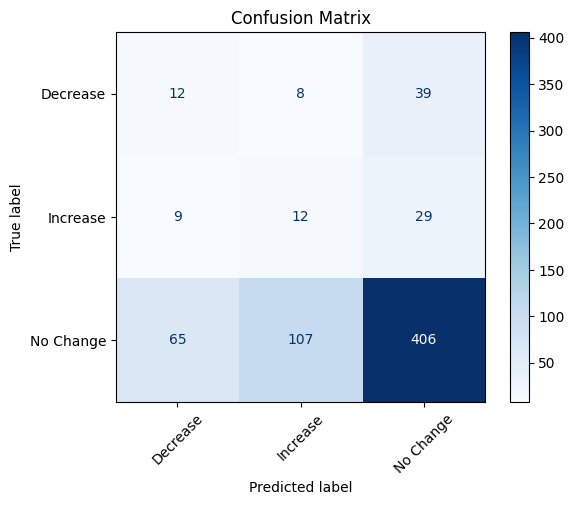


Classification Report:
              precision    recall  f1-score   support

    Decrease       0.14      0.20      0.17        59
    Increase       0.09      0.24      0.14        50
   No Change       0.86      0.70      0.77       578

    accuracy                           0.63       687
   macro avg       0.36      0.38      0.36       687
weighted avg       0.74      0.63      0.67       687



In [32]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=range(len(label_encoder.classes_)))
print(cm)

print()
# display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

## Iterpretation of Results

- "No Change" is the dominant category and is predicted with relatively high accuracy and precision.
- Categories "Decrease" and "Increase" are misclassified more often, with low precision and recall, despite training the model with a 10-fold `StratifiedKFold` strategy that preserves the percentage of samples for each category.
- This suggesting that this type of model struggles to distinguish between these categories due to the fewer samples.
